In [1]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.stats.weightstats import DescrStatsW

%matplotlib inline

In [2]:
output_paths = [
    'evosuite.csv',
    '~/evokex-16-15.csv', 
    "~/evokex-32-5.csv",
    # "~/evokex-32-15.csv", 
    # "~/evokex-16-15-u.csv",
    "~/evokex-32-5-u.csv",
    "~/evokex-32-5-g-1.csv",
    "~/evokex-32-5-g-2.csv",
    "~/evokex-32-5-g-3.csv",
]
raw_data: pd.DataFrame = None
for output_path in output_paths:
    tmp = pd.read_csv(output_path)
    if raw_data is None:
        raw_data = tmp
    else:
        raw_data = pd.concat([raw_data, tmp])

In [3]:
raw_data['project'] = raw_data['benchmark'].apply(lambda x: x[:x.rindex('-')])

In [4]:
raw_data = raw_data[raw_data['timeout'] == 120]

In [5]:
len(raw_data)

1365

In [6]:
tools = set(raw_data['tool'].unique())
timeouts = set(raw_data['timeout'].unique())

grouped = raw_data.groupby('benchmark')
mask = grouped.apply(lambda x: len(x.drop_duplicates(subset=['tool', 'timeout'])) == len(tools) * len(timeouts))
raw_data = raw_data[raw_data['benchmark'].map(mask)]

len(raw_data)

1365

In [7]:
for bench in mask.index:
    if not mask[bench]:
        print(bench)

In [8]:
data_indexed = raw_data.set_index(['tool', 'timeout', 'project'], drop=False).sort_index()

In [9]:
# data_indexed.loc['evokex-8-15', 120, 'SPOON'][['cut', 'run_number', 'tests', 'failing']]

In [10]:
def get_weighted_stats(x, w=None, mn=None, mx=None, **kwargs):
    stats = DescrStatsW(x, w, ddof=1)

    q1, q2, q3 = stats.quantile([0.25, 0.5, 0.75], return_pandas=False)
    iqr = q3 - q1

    whishi = q3 + 1.5 * iqr
    if mx is not None:
        whishi = min(mx, whishi)

    whislo = q1 - 1.5 * iqr
    if mn is not None:
        whislo = max(mn, whislo)

    fliers = x.loc[(x > whishi) | (x < whislo)]

    return {
        'mean': stats.mean,
        'q1': q1,
        'med': q2,
        'q3': q3,
        'iqr': iqr,
        'whishi': whishi,
        'whislo': whislo,
        'fliers': list(fliers),
        'std': stats.std,
        **kwargs
    }


In [11]:
tools = list(data_indexed.index.unique(0))
timeouts = list(data_indexed.index.unique(1))
projects = list(data_indexed.index.unique(2))

In [12]:
def full_stats_dict():
    return {
        'default': None,
        'weighted': None,
        '1 / weighted': None,
    }


def compute_stats_by(df: pd.DataFrame, name: str, mod: str, weighted: int) -> dict:
    label = f'{name}_{mod}'
    weights = None
    if weighted == 1:
        label += ' (w)'
        weights = df[f'{name}_total']
    elif weighted == 2:
        label += ' (1/w)'
        weights = 1. / (df[f'{name}_total'] + 1)
    return get_weighted_stats(
        df[f'{name}_{mod}_ratio'],
        weights,
        mn=0, mx=100,
        label=label
    )


def compute_stats(df: pd.DataFrame, weighted: int) -> dict:
    return {
        'lines_coverage': compute_stats_by(df, 'lines', 'coverage', weighted),
        'branches_coverage': compute_stats_by(df, 'branches', 'coverage', weighted),
        'instructions_coverage': compute_stats_by(df, 'instructions', 'coverage', weighted),
        'complexity_coverage': compute_stats_by(df, 'complexity', 'coverage', weighted),
    }


global_stats = defaultdict(
    lambda: defaultdict(
        lambda: {
            'projects': defaultdict(lambda: full_stats_dict()),
            **full_stats_dict()
        }
    )
)

for tool in tools:
    for timeout in timeouts:
        dt = data_indexed.loc[tool, timeout]
        stats = global_stats[tool][timeout]
        stats['default'] = compute_stats(dt, weighted=0)
        stats['weighted'] = compute_stats(dt, weighted=1)
        stats['1 / weighted'] = compute_stats(dt, weighted=2)

        stats = stats['projects']
        for project in projects:
            dt = data_indexed.loc[tool, timeout, project]
            p_stats = stats[project]
            p_stats['default'] = compute_stats(dt, weighted=0)
            p_stats['weighted'] = compute_stats(dt, weighted=1)
            p_stats['1 / weighted'] = compute_stats(dt, weighted=2)

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/weightstats.py:196: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/weightstats.py:196: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/weightstats.py:196: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/weightstats.py:196: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/weightstats.py:196: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/weightstats.py:196: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/weightstats.

In [13]:
table = pd.DataFrame(
    index=pd.MultiIndex.from_product([['ALL'] + projects, timeouts, tools], names=['project', 'timeout', 'tool']),
    columns=['lines', 'branches', 'instructions', 'complexity', 'lines (w)', 'branches (w)', 'instructions (w)', 'complexity (w)', 'lines (1/w)', 'branches (1/w)', 'instructions (1/w)', 'complexity (1/w)']
)

metric = 'mean'

def extract(x):
    return [x['lines_coverage'][metric], x['branches_coverage'][metric], x['instructions_coverage'][metric],
            x['complexity_coverage'][metric]]


for timeout in timeouts:
    for tool in tools:
        stats = global_stats[tool][timeout]
        item = [*extract(stats['default']), *extract(stats['weighted']), *extract(stats['1 / weighted'])]
        table.loc['ALL', timeout, tool] = item
        for project in projects:
            stats = global_stats[tool][timeout]['projects'][project]
            item = [*extract(stats['default']), *extract(stats['weighted']), *extract(stats['1 / weighted'])]
            table.loc[project, timeout, tool] = item

table[[col for col in table if col.startswith('lines')]]

lines  lines (w) lines (1/w)
project  timeout tool                                             
ALL      120     evokex-16-15     60.418769  53.665019   67.356481
                 evokex-32-5      62.405538  55.837221   66.003016
                 evokex-32-5-g-1  57.460462  51.667707   63.664072
                 evokex-32-5-g-2  43.904718  42.725051   51.461738
                 evokex-32-5-g-3  60.244051  54.052947   63.491322
                 evokex-32-5-u    57.779231  53.951815   65.465531
                 evosuite-mo      55.783846   48.09446   63.659635
FASTJSON 120     evokex-16-15       60.8715  57.048459    61.33792
                 evokex-32-5        64.4035  55.952305   63.465459
                 evokex-32-5-g-1     60.147    54.1235   63.126319
                 evokex-32-5-g-2  46.687667  47.708472   46.472814
                 evokex-32-5-g-3  64.727833  55.925505   65.232063
                 evokex-32-5-u       63.963  60.484464   67.052339
                 evosuite-mo        68.6895  56.083599   71.538688
GUAVA    120     evokex-16-15     72.246667  71.515793   76.983269
                 evokex-32-5      76.945333  77.176568   79.102956
                 evokex-32-5-g-1  57.853111  62.572639   55.320686
                 evokex-32-5-g-2  57.340667   62.97881   53.899024
                 evokex-32-5-g-3  69.614889  70.209158   69.531191
                 evokex-32-5-u        49.13  54.268249   49.074257
                 evosuite-mo      51.761333  47.038728   63.193516
SEATA    120     evokex-16-15         69.11  52.006113   84.649511
                 evokex-32-5      62.396667  45.802847   77.694212
                 evokex-32-5-g-1  64.354444  46.685332   80.139815
                 evokex-32-5-g-2  28.930444  12.288023   58.126437
                 evokex-32-5-g-3  63.074667  48.084313   77.546642
                 evokex-32-5-u    66.252667  47.445502   83.081817
                 evosuite-mo         62.818  43.523394   82.120253
SPOON    120     evokex-16-15        39.296  25.104285   48.958761
                 evokex-32-5      45.210667  44.100318   48.203493
                 evokex-32-5-g-1  46.591778  36.373782    52.92226
                 evokex-32-5-g-2  41.732444  32.133757   47.317762
                 evokex-32-5-g-3  42.064222  36.848301   44.315734
                 evokex-32-5-u        49.71  34.643456   56.918415
                 evosuite-mo      35.564667  22.761808   39.231516

In [14]:
metrics = [
    'lines_coverage',
    'branches_coverage',
    'instructions_coverage',
    'complexity_coverage',
]

print('tools:', ', '.join(tools))
print('timeouts:', ', '.join([str(x) for x in timeouts]))
print('projects:', ', '.join(projects))
print('metrics:', ', '.join(metrics))

tools: evokex-16-15, evokex-32-5, evokex-32-5-g-1, evokex-32-5-g-2, evokex-32-5-g-3, evokex-32-5-u, evosuite-mo
timeouts: 120
projects: FASTJSON, GUAVA, SEATA, SPOON
metrics: lines_coverage, branches_coverage, instructions_coverage, complexity_coverage


In [15]:
def get_cmap(n, name='brg'):
    return plt.colormaps.get_cmap(name).resampled(n)


def draw_boxplots(ax: plt.Axes, labels, mods, get_stats, width=0.07, gap=1):
    colors = get_cmap(len(mods))
    n = len(mods)
    pos_diff = np.linspace(-n + 1, n - 1, n) * (width / 2)
    x_tick_label = []
    x_tick_position = []

    for i, label in enumerate(labels):
        for j, mod in enumerate(mods):
            x_tick_label.append(label)
            x_tick_position.append(i * gap)
            p = i * gap + pos_diff[j]

            stats = get_stats(label, mod)
            bxp = ax.bxp([stats], widths=[width], patch_artist=True, positions=[p])
            for box in bxp["boxes"]:
                box.update(dict(
                    facecolor=colors(j),
                    zorder=.9,
                    edgecolor='gray',
                ))
            if i == 0:
                rect = plt.Rectangle((0, 0), 0, 0,
                                     linewidth=0,
                                     edgecolor='gray',
                                     facecolor=colors(j),
                                     label=mod)
                ax.add_patch(rect)

    plt.xticks(x_tick_position, x_tick_label)


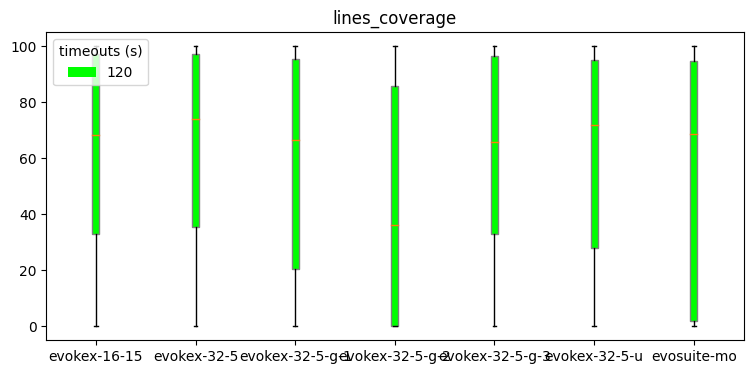

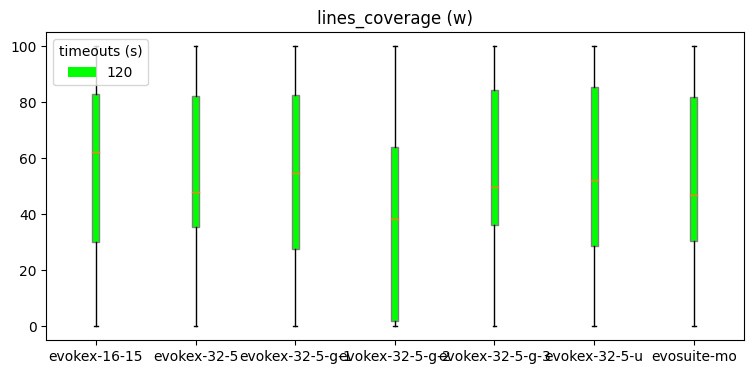

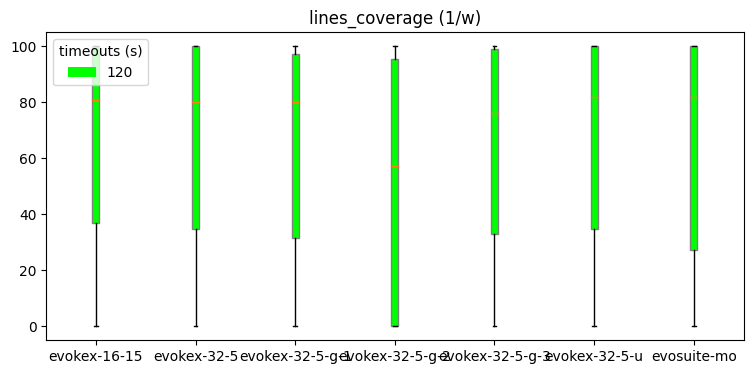

In [16]:
metric = 'lines_coverage'
project = None # or None

for weighted in [0, 1, 2]:
    fig, ax = plt.subplots(figsize=(9, 4))
    
    def get_stats(tool, timeout):
        stats = global_stats[tool][timeout] if project is None else global_stats[tool][timeout]['projects'][project]
        if weighted == 0:
            stats = stats['default']
        elif weighted == 1:
            stats = stats['weighted']
        else:
            stats = stats['1 / weighted']
        return stats[metric]
    
    draw_boxplots(ax, tools, timeouts, get_stats)
    
    ax.legend(loc='upper left', title='timeouts (s)')
    title = metric if project is None else f'{project}: {metric}'
    if weighted == 1:
        title += ' (w)'
    elif weighted == 2:
        title += ' (1/w)'
    ax.set_title(title)

plt.show()


In [17]:
def draw_per_project(metric, weighted, tool):
    fig, ax = plt.subplots(figsize=(9, 4))

    def get_stats(project, timeout):
        stats = global_stats[tool][timeout]['projects'][project]
        if weighted == 0:
            stats = stats['default']
        elif weighted == 1:
            stats = stats['weighted']
        else:
            stats = stats['1 / weighted']
        return stats[metric]

    draw_boxplots(ax, projects, timeouts, get_stats, 0.15)

    ax.legend(loc='upper left', title='timeouts (s)', bbox_to_anchor=(1, 1))
    title = f'{tool}: {metric}'
    if weighted == 1:
        title += ' (w)'
    elif weighted == 2:
        title += ' (1/w)'
    ax.set_title(title)


/tmp/ipykernel_7473/3144074391.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(9, 4))


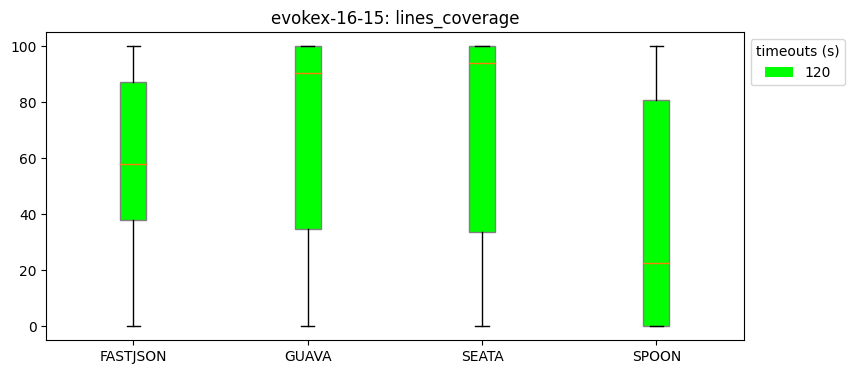

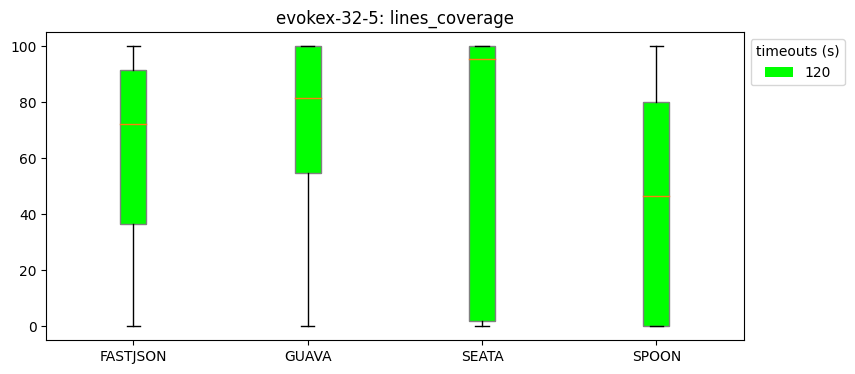

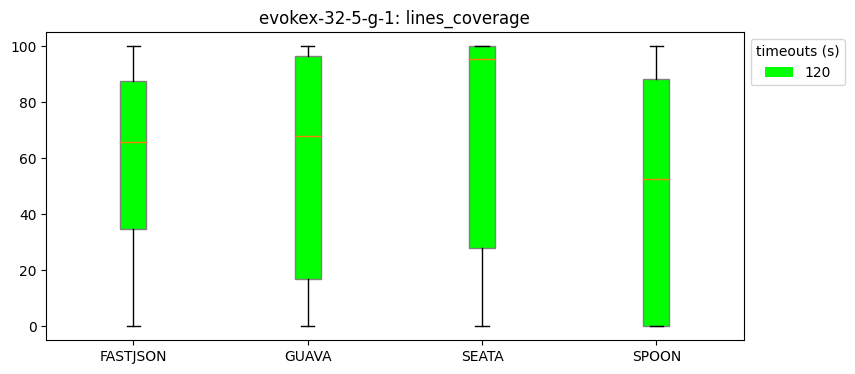

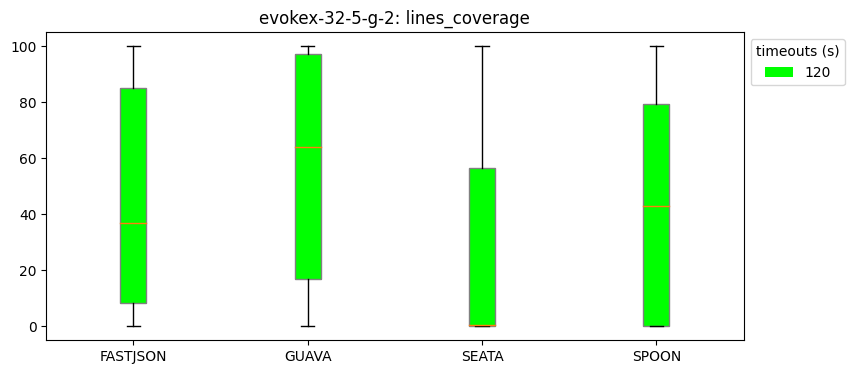

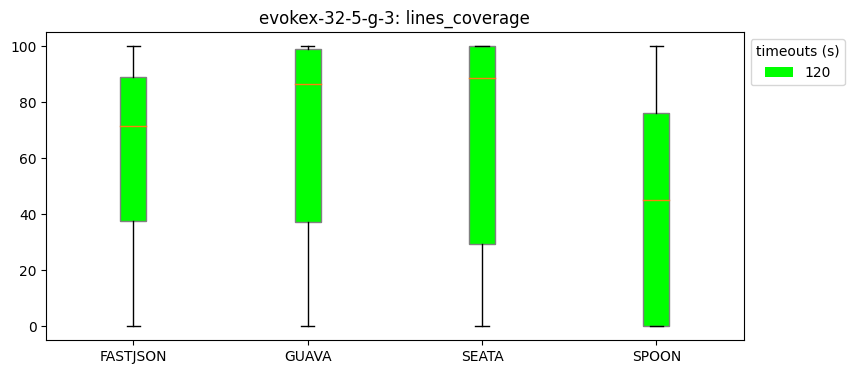

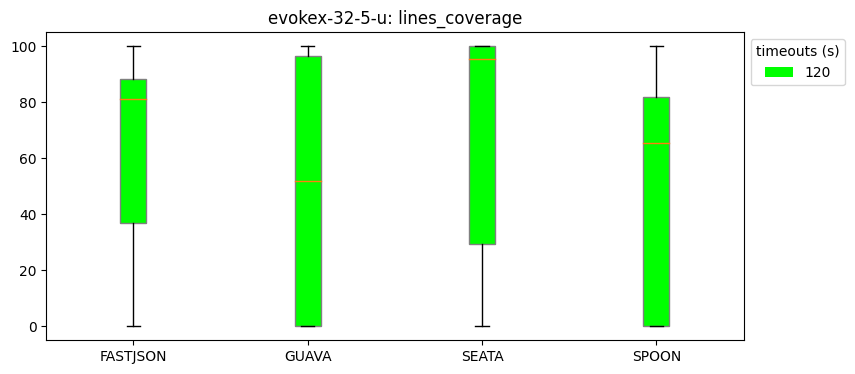

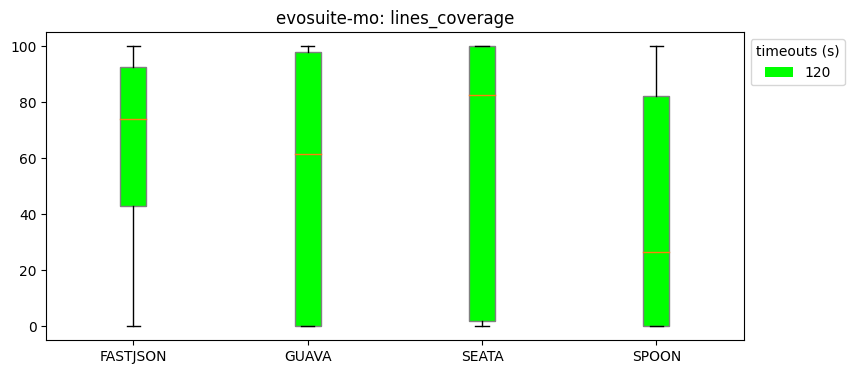

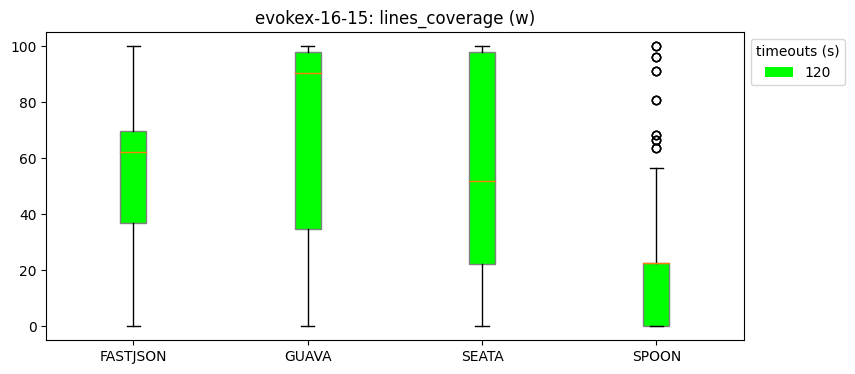

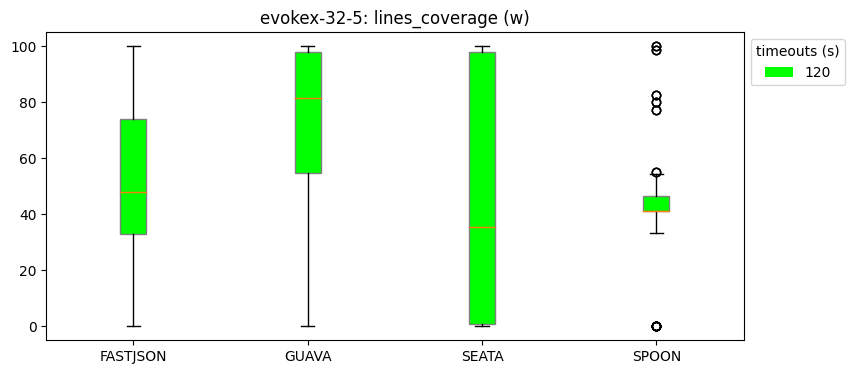

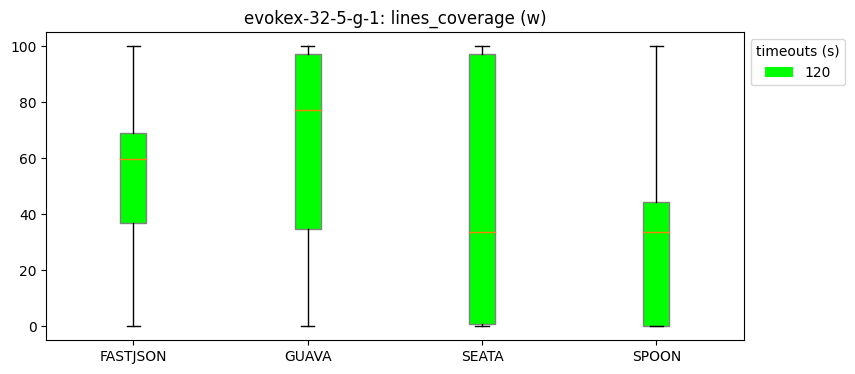

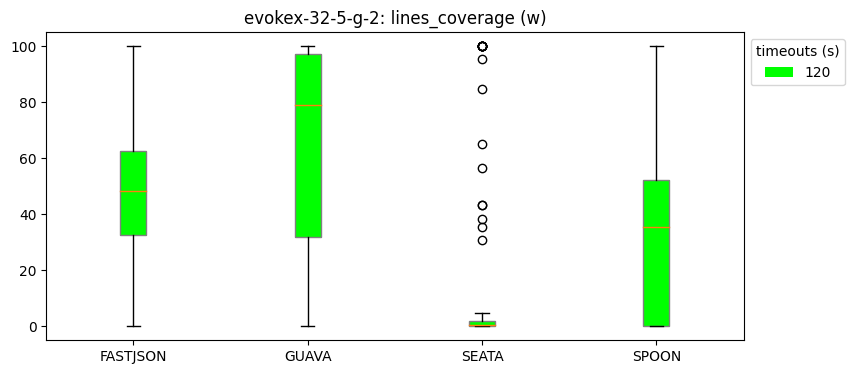

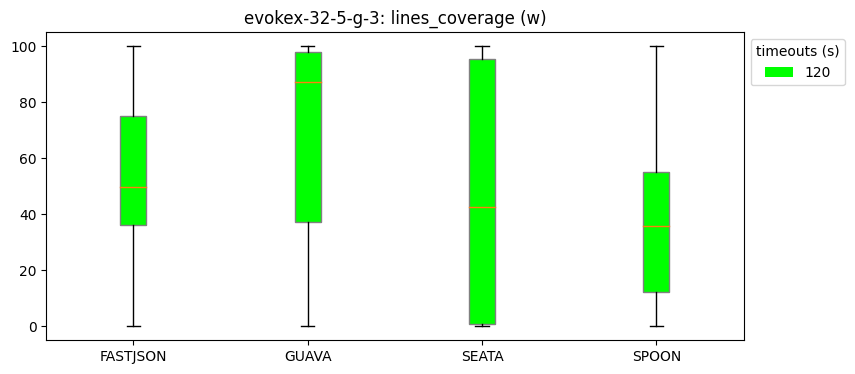

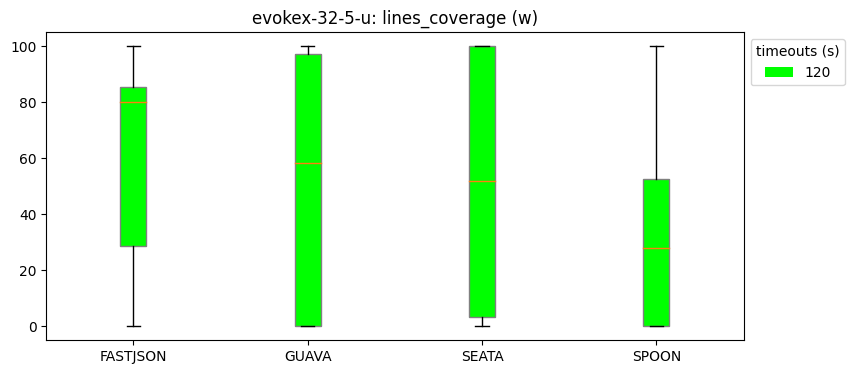

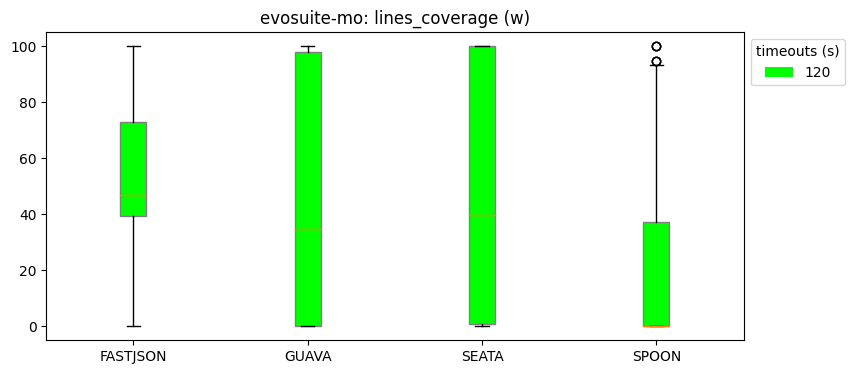

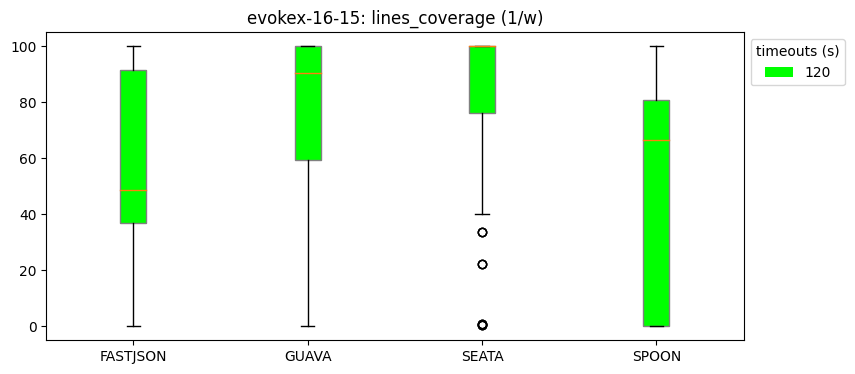

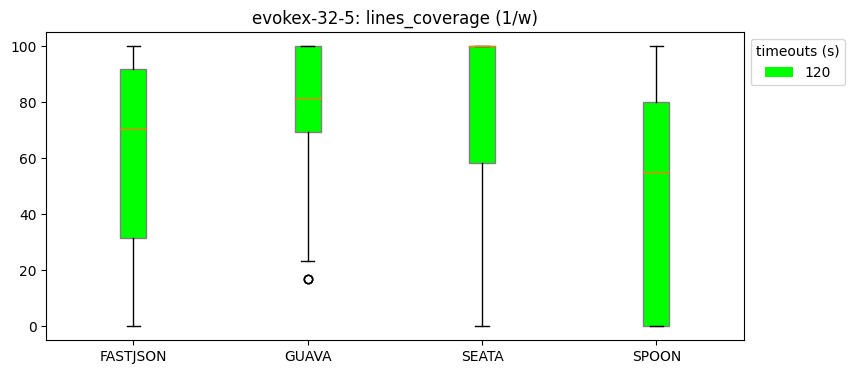

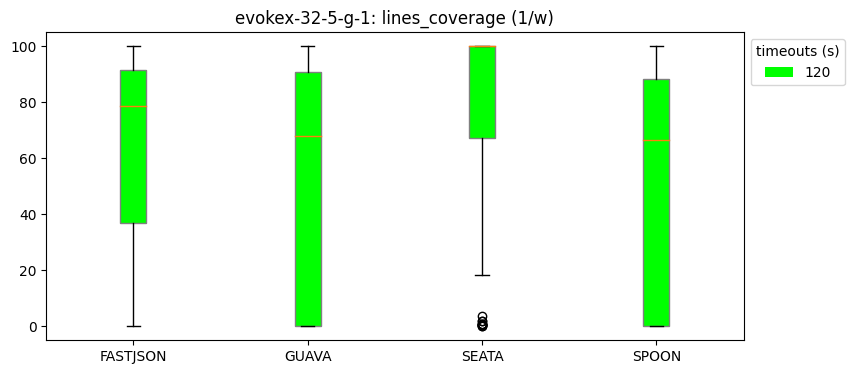

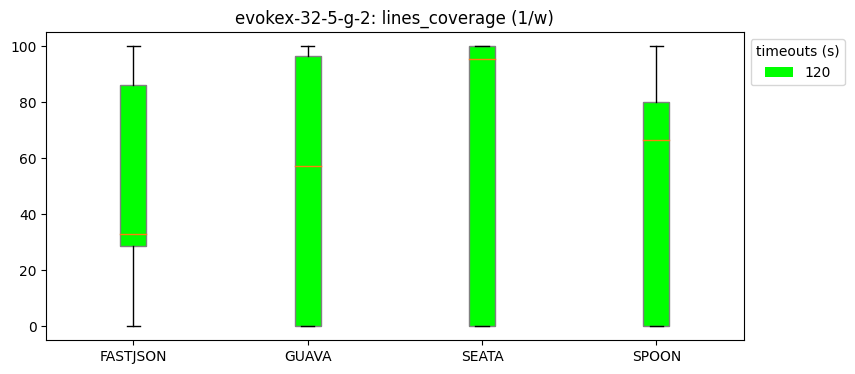

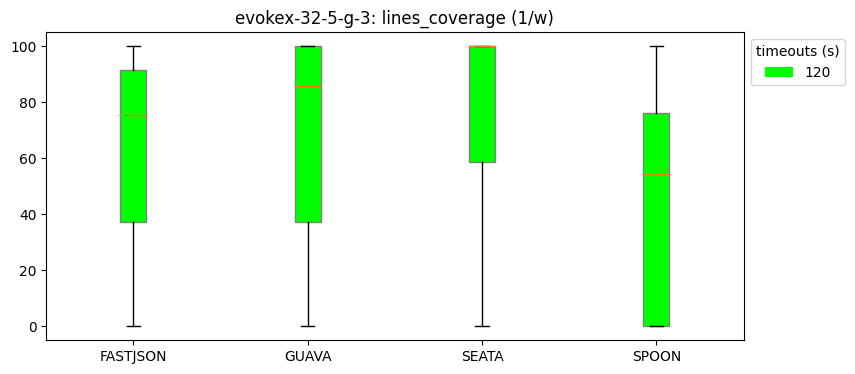

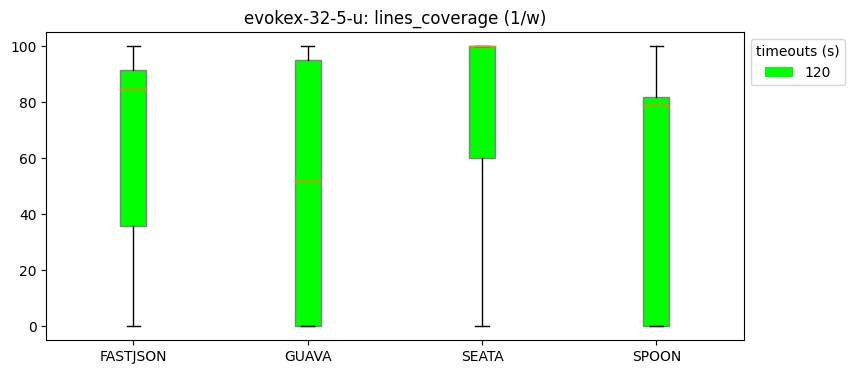

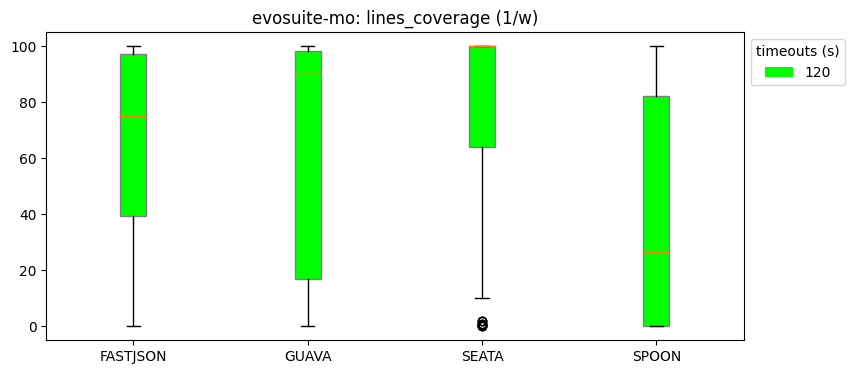

In [18]:
metric = 'lines_coverage'
# weighted = False
for weighted in [0, 1, 2]:
    for tool in tools:
        draw_per_project(metric, weighted, tool)
plt.show()

In [18]:
for project in projects:
    benchs = data_indexed.loc[tools[0], timeouts[0], project]['benchmark'].nunique()
    print(f'{project}: {benchs}')

COLLECTIONS: 25
JSOUP: 14
SPATIAL4J: 13
TA4J: 30
THREETEN-EXTRA: 18


/usr/local/lib/python3.10/dist-packages/statsmodels/stats/weightstats.py:196: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/weightstats.py:196: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/weightstats.py:196: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var)


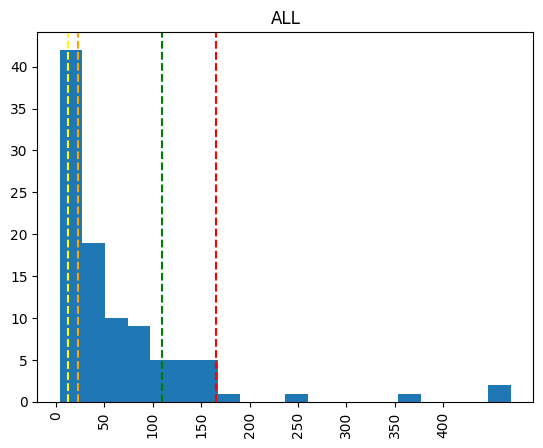

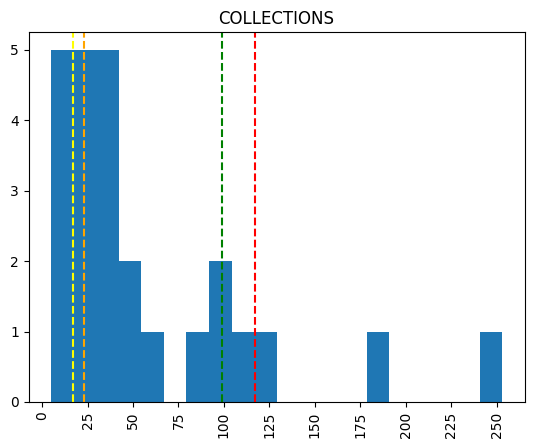

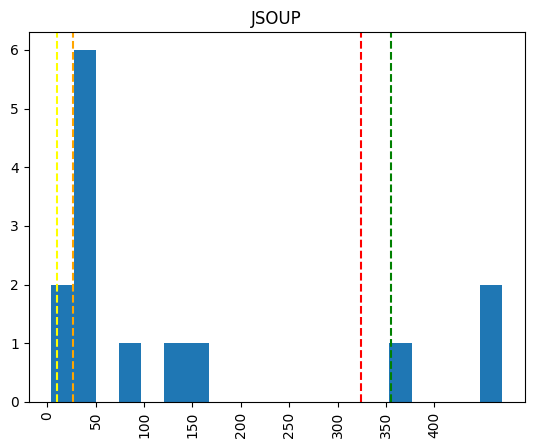

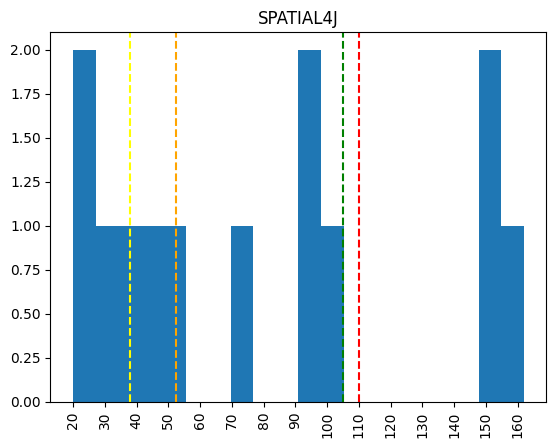

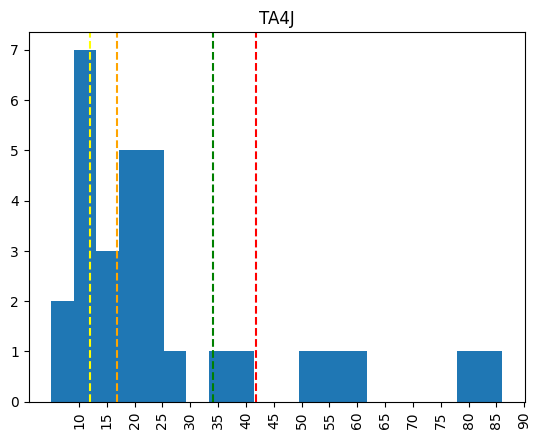

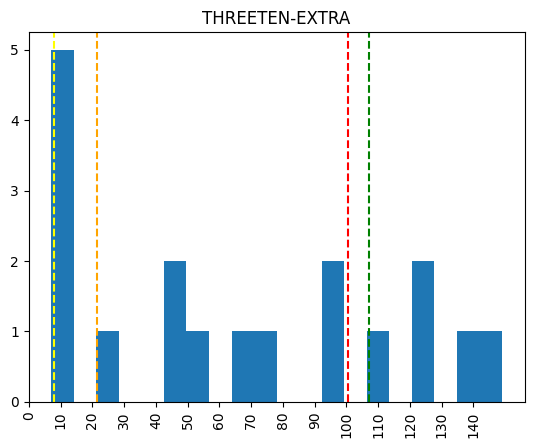

In [19]:
def draw_hist(ax, data):
    ax.hist(data, bins=20)
    x_ticks = ax.get_xticks()[1:-1]
    n = len(x_ticks)
    x_ticks = np.linspace(min(x_ticks), max(x_ticks), num=n*2 - 1)
    x_labels = [f'{x:.0f}' for x in x_ticks]
    ax.set_xticks(x_ticks, x_labels, rotation=90)
    
    stats = get_weighted_stats(data, 1 / data)
    ax.axvline(x=stats['mean'], color='orange', linestyle='--')
    ax.axvline(x=stats['med'], color='yellow', linestyle='--')


    stats = get_weighted_stats(data, data)
    ax.axvline(x=stats['mean'], color='red', linestyle='--')
    ax.axvline(x=stats['med'], color='green', linestyle='--')
    
    # med = np.median(data)
    # ax.axvline(x=med, color='red', linestyle='--')
    # 
    # mean = np.mean(data)
    # ax.axvline(x=mean, color='green', linestyle='--')

metric = 'lines'

fig, ax = plt.subplots()
benchs = data_indexed.loc[tools[0], timeouts[0], :]
data = benchs[benchs['run_number'] == 1][f'{metric}_total']
draw_hist(ax, data)
ax.set_title('ALL')

for project in projects:
    fig, ax = plt.subplots()
    
    benchs = data_indexed.loc[tools[0], timeouts[0], project]
    data = benchs[benchs['run_number'] == 1][f'{metric}_total']
    draw_hist(ax, data)
    ax.set_title(project)
plt.show()

In [20]:
metric = 'lines'
total = f'{metric}_total'
coverage = f'{metric}_coverage_ratio'
project = None

def choose_winner_impl(x):
    x.set_index('tool', inplace=True)
    max_coverage = x[coverage].max()
    winners = [tool for tool in tools if x.loc[tool][coverage] == max_coverage]
    return pd.Series([winners, max_coverage, x[total][0]], index=['winners', coverage, total])

def choose_winner(x):
    x = x.groupby(['tool', 'timeout']).apply(lambda y: y[[coverage, total]].mean()).reset_index()
    return x.groupby('timeout').apply(choose_winner_impl)

winners = raw_data
if project is not None:
    winners = winners[winners['project'] == project]
winners = winners.groupby('benchmark').apply(choose_winner).reset_index()
winners

,benchmark,timeout,winners,lines_coverage_ratio,lines_total
0,COLLECTIONS-1,30,[evokex-32-5-u],66.050000,54.0
1,COLLECTIONS-1,60,[evosuite-mo],99.383333,54.0
2,COLLECTIONS-1,120,[evosuite-mo],99.383333,54.0
3,COLLECTIONS-10,30,[evokex-32-5],91.026667,26.0
4,COLLECTIONS-10,60,"[evokex-32-5, evokex-32-5-u, evosuite-mo]",100.000000,26.0
...,...,...,...,...,...
295,THREETEN-EXTRA-98,60,"[evokex-32-5, evokex-32-5-u, evosuite-mo]",100.000000,24.0
296,THREETEN-EXTRA-98,120,"[evokex-32-5, evokex-32-5-u, evosuite-mo]",100.000000,24.0
297,THREETEN-EXTRA-99,30,[evosuite-mo],82.863333,107.0
298,THREETEN-EXTRA-99,60,[evokex-32-5],80.060000,107.0


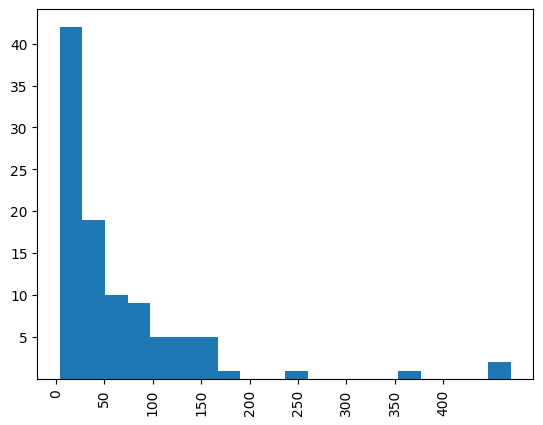

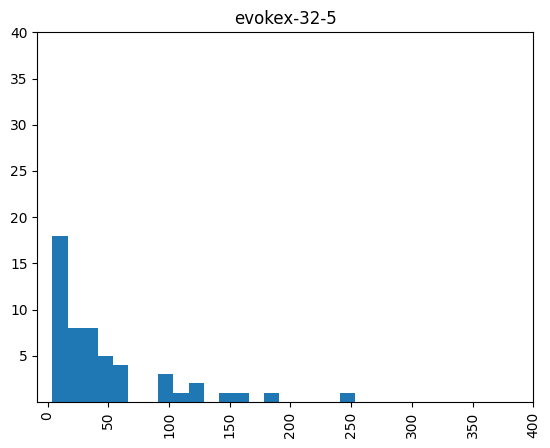

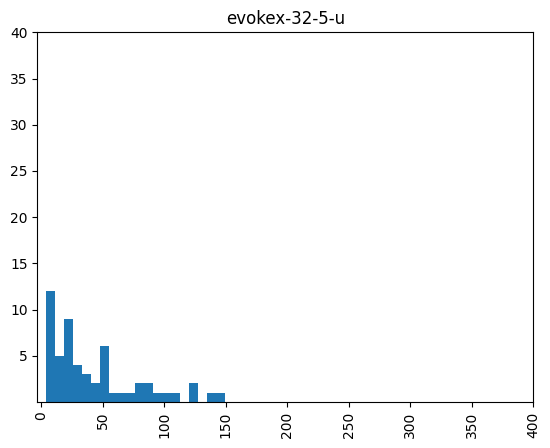

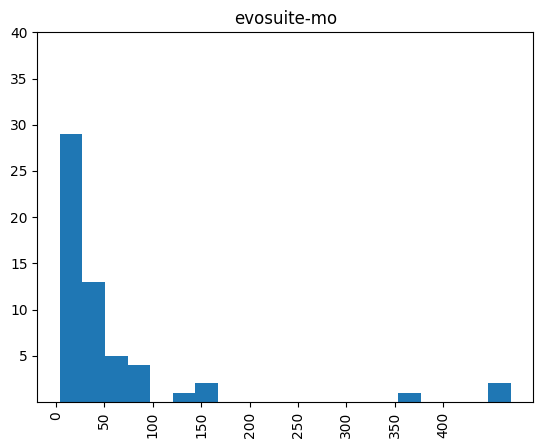

In [21]:
timeout = 120

_, ax = plt.subplots()
if project is not None:
    benchs = data_indexed.loc[tools[0], timeout, project]
else:
    benchs = data_indexed.loc[tools[0], timeout, :]
data = benchs[benchs['run_number'] == 1][total]
ax.hist(data, bins=20)
x_ticks = ax.get_xticks()[1:-1]
n = len(x_ticks)
x_ticks = np.linspace(min(x_ticks), max(x_ticks), num=n*2 - 1)
x_labels = [f'{x:.0f}' for x in x_ticks]
ax.set_xticks(x_ticks, x_labels, rotation=90)

y_ticks = ax.get_yticks()[1:-1]
y_labels = [f'{x:.0f}' for x in y_ticks]
ax.set_yticks(y_ticks, y_labels)

for tool in tools:
    _, ax = plt.subplots()
    ax.set_title(f'{tool}')
    data = winners[winners['timeout'] == timeout]
    mask = data['winners'].map(lambda x: tool in x)
    data = data[mask][total]
    ax.hist(data, bins=20)
    ax.set_xticks(x_ticks, x_labels, rotation=90)
    ax.set_yticks(y_ticks, y_labels)

plt.show()